Population DataFrame Columns: Index(['Country', 'Capital', 'Area', 'Population (2021)'], dtype='object')
   Country           Capital         Area Population (2021)
0  Albania            Tirana   28,748 km²       2.8 million
1  Andorra  Andorra la Vella      468 km²            77,335
2  Austria            Vienna   83,858 km²         9 million
3  Belarus             Minsk  207,560 km²       9.4 million
4  Belgium          Brussels   30,528 km²      11.6 million
GDP DataFrame Columns: Index(['Country', '2024[4]', '2023[5]', '2022', '2021[6]', '2020[6]', '2019',
       '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010'],
      dtype='object')
          Country    2024[4]    2023[5]       2022    2021[6]    2020[6]  \
0         Germany  4,683.233  4,429.840  4,256.540  4,230.172  3,780.553   
1  United Kingdom  3,557.465  3,332.060  3,376.003  3,108.416  2,638.296   
2          France  3,156.325  3,049.020  2,936.702  2,940.428  2,551.451   
3           Italy  2,365.541

<ipython-input-7-f4c35d87c9af>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[['Population', 'Population Density', 'GDP per capita', 'GDP in 2024']] = dff[['Population', 'Population Density', 'GDP per capita', 'GDP in 2024']].apply(pd.to_numeric, errors='coerce')


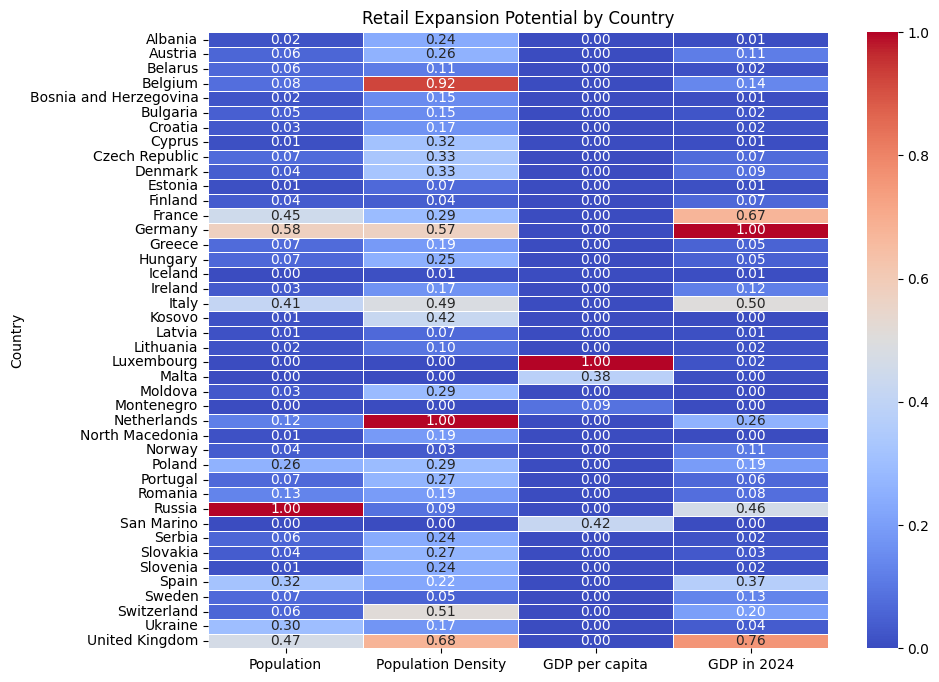

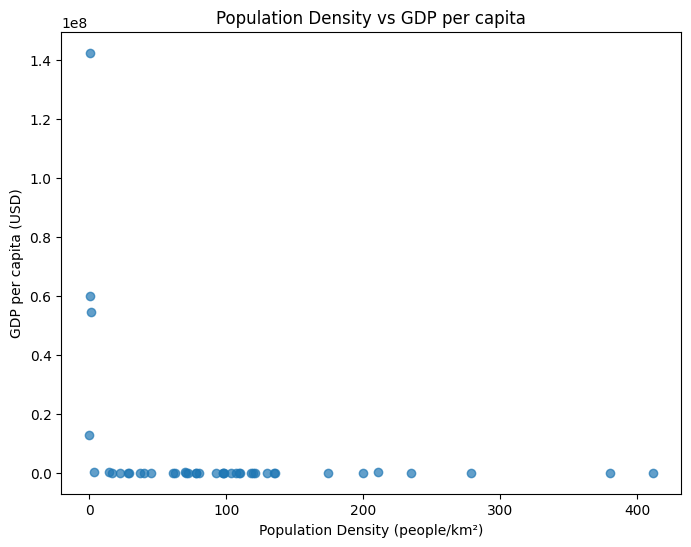

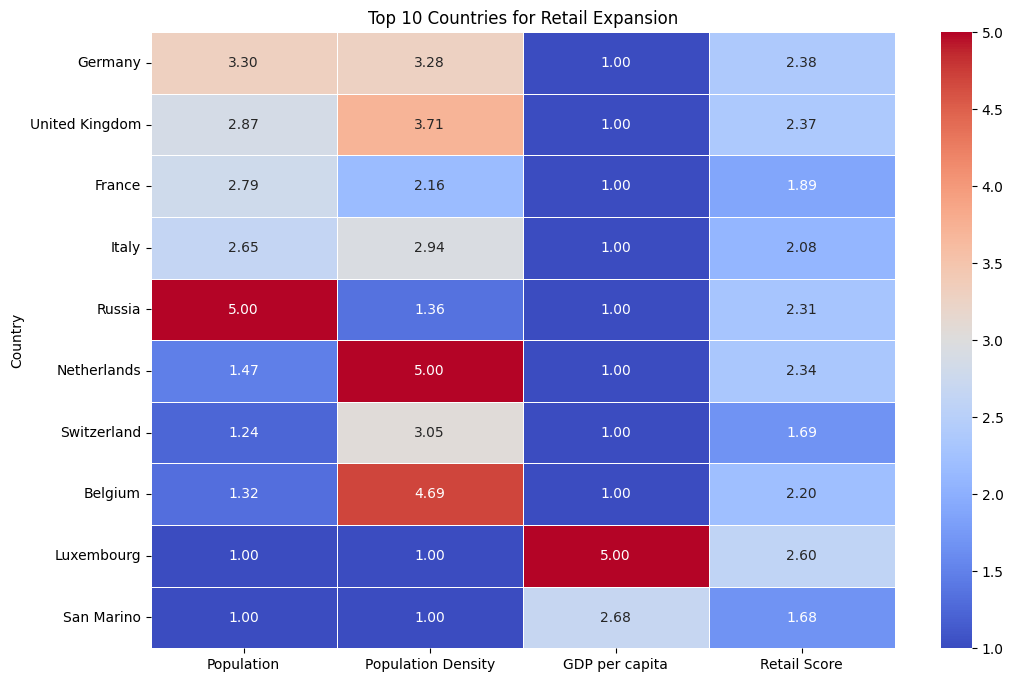

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns

# Request data
presponse = requests.get('https://visaguide.world/europe/')
gdpresponse = requests.get('https://en.m.wikipedia.org/wiki/List_of_sovereign_states_in_Europe_by_GDP_(nominal)')

# Parse HTML content using BeautifulSoup
popsoup = BeautifulSoup(presponse.content, 'html.parser')
gdpsoup = BeautifulSoup(gdpresponse.content, 'html.parser')

# Extract tables from both websites
poptable = popsoup.find_all('table')
gdptable = gdpsoup.find_all('table')

# Extract headers for population data (Visa guide)
popheadings = poptable[1].find_all('th')
popheadings = [heading.get_text(strip=True) for heading in popheadings]

# Extract headers for GDP data (Wikipedia)
gdpheadings = gdptable[0].find_all('th')
gdpheadings = [heading.get_text(strip=True) for heading in gdpheadings]

# Extract rows for population and GDP data
poprows = poptable[1].find_all('td')
gdprows = gdptable[0].find_all('td')

# Convert population data to a list of values
poprows = [cell.get_text(strip=True) for cell in poprows]
gdprows = [cell.get_text(strip=True) for cell in gdprows]

# Organize population data into a dictionary
popdict = {}
n = 0
for i in popheadings:
    popdict[i] = [poprows[j] for j in range(n, len(poprows), len(popheadings))]
    n += 1

# Organize GDP data into a dictionary
gdpdict = {}
n = 0
for i in gdpheadings:
    gdpdict[i] = [gdprows[j] for j in range(n, len(gdprows), len(gdpheadings))]
    n += 1

# Create dataframes from the dictionaries
popdf = pd.DataFrame(popdict)
gdpdf = pd.DataFrame(gdpdict)

# Debugging: Print columns and first few rows to check
print("Population DataFrame Columns:", popdf.columns)
print(popdf.head())
print("GDP DataFrame Columns:", gdpdf.columns)
print(gdpdf.head())

# Rename columns for clarity
popdf.rename(columns={"Country": "Country", "Population (2021)": "Population", "Area": "Area"}, inplace=True)
gdpdf.rename(columns={"Country": "Country", "2024[4]": "GDP in 2024"}, inplace=True)

# Check the columns again after renaming
print("Renamed Population DataFrame Columns:", popdf.columns)
print(popdf.head())
print("Renamed GDP DataFrame Columns:", gdpdf.columns)
print(gdpdf.head())

# Clean population data (remove 'million' and convert to float)
popdf['Population'] = popdf['Population'].apply(lambda x: float(x.replace('million', '').replace(',', '').strip()) * 1_000_000 if 'million' in x else float(x.replace(',', '').strip()))

# Clean area data (remove 'km²' and commas)
popdf['Area'] = popdf['Area'].apply(lambda x: float(x.replace(',', '').replace('km²', '').strip()))

# Add population density
popdf['Population Density'] = popdf['Population'] / popdf['Area']

# Merge the population and GDP dataframes based on 'Country'
finaldata = pd.merge(popdf, gdpdf, on="Country", how="inner")

# Clean GDP data (remove commas and convert to float)
finaldata['GDP in 2024'] = finaldata['GDP in 2024'].replace({',': ''}, regex=True).astype(float)

# Calculate GDP per capita
finaldata['GDP per capita'] = finaldata['GDP in 2024'] * 1_000_000_000 / finaldata['Population']

# Select relevant columns for analysis
dff = finaldata[['Country', 'Population', 'Population Density', 'GDP per capita', 'GDP in 2024']]

# Convert all numeric columns to numeric types, forcing errors to NaN (useful if there are any non-numeric values)
dff[['Population', 'Population Density', 'GDP per capita', 'GDP in 2024']] = dff[['Population', 'Population Density', 'GDP per capita', 'GDP in 2024']].apply(pd.to_numeric, errors='coerce')

# Normalize the data (only for numeric columns)
dff = dff.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.name != 'Country' else x, axis=0)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(dff.set_index('Country'), annot=True, fmt='.2f', cmap="coolwarm", linewidths=0.5)
plt.title('Retail Expansion Potential by Country')
plt.show()

# Sorting the final data by GDP in 2024
finaldata.sort_values(by='GDP in 2024', ascending=False, inplace=True)

# Generate a scatter plot between population density and GDP per capita
plt.figure(figsize=(8, 6))
plt.scatter(finaldata['Population Density'], finaldata['GDP per capita'], alpha=0.7)
plt.title("Population Density vs GDP per capita")
plt.xlabel("Population Density (people/km²)")
plt.ylabel("GDP per capita (USD)")
plt.show()

# Apply a retail score based on population, GDP per capita, and population density
weights = {
    "GDP per capita": 0.4,
    "Population": 0.3,
    "Population Density": 0.3
}

df_scaled = finaldata[['Country', 'Population', 'Population Density', 'GDP per capita']].copy()

# Scale each feature between 1 and 5
for col in weights.keys():
    df_scaled[col] = 1 + 4 * (df_scaled[col] - df_scaled[col].min()) / (df_scaled[col].max() - df_scaled[col].min())

# Calculate Retail Score
df_scaled["Retail Score"] = sum(df_scaled[col] * weight for col, weight in weights.items())

# Get top 10 countries for retail expansion based on retail score
top_10_countries = df_scaled.nlargest(10, "Retail Score")[["Country", "Retail Score"]]

# Set country as index for heatmap
df_top_10 = df_scaled[df_scaled["Country"].isin(top_10_countries["Country"])].set_index("Country")

# Plot heatmap for top 10 countries
plt.figure(figsize=(12, 8))
sns.heatmap(df_top_10, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Top 10 Countries for Retail Expansion")
plt.show()

# Store the final data into a CSV file
finaldata.to_csv("europedata.csv", index=False)
